In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('jamb_exam_results.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')


In [3]:
df.isnull().sum()

jamb_score                        0
study_hours_per_week              0
attendance_rate                   0
teacher_quality                   0
distance_to_school                0
school_type                       0
school_location                   0
extra_tutorials                   0
access_to_learning_materials      0
parent_involvement                0
it_knowledge                      0
student_id                        0
age                               0
gender                            0
socioeconomic_status              0
parent_education_level          891
assignments_completed             0
dtype: int64

In [4]:
del df['student_id']
df['parent_education_level'].fillna(0, inplace=True)


In [5]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(3000, 1000, 1000)

In [6]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

One-hot encoding

In [7]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=True)




train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

Training decision tree regression

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
# Assuming X_train contains the feature data and y_train contains the target variable 'jamb_score'
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

# Find the feature used for splitting
feature_index = model.tree_.feature[0]
#feature_name = X_train.columns[feature_index]
#print(f"The feature used for splitting is: {feature_name}")
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



In [9]:
y_pred = model.predict_proba(X_val)[:, 1]
term_deposit_decision = (y_pred >= 0.5)
(y_val == term_deposit_decision).mean()

0.0

AUC of validation DS

In [10]:
auc = roc_auc_score(y_val, y_pred)
print(auc)
print('%.3f' % (auc))

NameError: name 'roc_auc_score' is not defined

Precision and recall


In [17]:
thresholds = np.linspace(0, 1, 101)
# Lists to store precision and recall values for each threshold
precisions = []
recalls = []
f1_scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    precisions.append(p)
    recalls.append(r)
    # Calculate F1 score
    f1_score = (2 * p * r) / (p + r) if (p + r) > 0 else 0
    f1_scores.append(f1_score)


/tmp/ipykernel_245906/1041380374.py:17: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


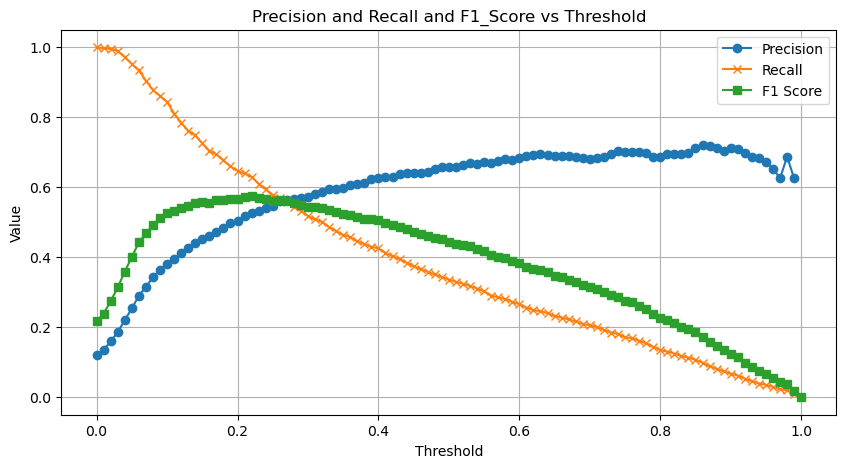

In [18]:
# Plot Precision and Recall vs. Threshold
plt.figure(figsize=(10, 5))

# Plot precision
plt.plot(thresholds, precisions, label='Precision', marker='o')
# Plot recall
plt.plot(thresholds, recalls, label='Recall', marker='x')
# Plot F1 score
plt.plot(thresholds, f1_scores, label='F1 Score', marker='s')

# Add labels and legend
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Precision and Recall and F1_Score vs Threshold')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

Answer 3: Values intersect at 0.265
Answer 4: Max F1 Score is at 0.22 

Cross-Validation

In [19]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [20]:
dv, model = train(df_train, y_train, C=0.001)

In [21]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [22]:
y_pred = predict(df_val, dv, model)

In [24]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [29]:
#for C in tqdm([1]):
for C in tqdm([0.000001, 0.001, 1]):    
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.701 +- 0.009
C=0.001 0.861 +- 0.007
C=1 0.906 +- 0.006


Answer 5: 0.006 
Answer 6: C=1 with best mean score